# Process Repeated Trials

Given a directory of repeated trials, aggregate outputs/predictions to be more coherent

In [1]:
import os,sys
import torch
import numpy as np
import pandas as pd
import scipy.stats as stats
import shutil

sys.path.insert(0, 'src')
from utils.utils import copy_tree, ensure_dir
from explainer_generate_csv import generate_csv, get_outputs
from utils.visualizations import bar_graph

## Processing 

### Function Definitions

In [2]:
def copy_repeated_trials(paths, overwrite=False):
    '''
    Given a list of pairs of paths, copy trials from src to dst/repeated_trials
    
    Arg(s):
        paths : list[(str, str)]
            (src, dst) : where dst is parent of 'repeated_trials' directory
            
    '''
    for idx, (src_path, dst_path) in enumerate(paths):
        print("Processing {}/{}: {} -> {}".format(idx + 1, len(paths), src_path, dst_path))
        try:
            dst_path = os.path.join(dst_path, 'repeated_trials')
            if not os.path.exists(dst_path):
                copy_tree(src_path, dst_path)
            if os.path.exists(dst_path) and overwrite:
                print("Overwriting files at {}".format(dst_path))
                shutil.rmtree(dst_path)
                copy_tree(src_path, dst_path)
            else:
                print("Directory {} exists and not overwriting".format(dst_path))
                continue
            
        except Exception as e:
            print("Unable to copy directory {} to {}: {}".format(src_path, dst_path, e))
            
            
def aggregate_outputs(repeated_trials_dir):
    '''
    Given a directory of repeated trials, create Numpy arrays of outputs, probabilities, and predictions
    
    Arg(s):
        repeated_trials_dir : str
            parent of where trial directories are stored
    Returns:
        dict[str : np.array]
            outputs : n_trials x n_samples x n_classes np.array
                explainer outputs
            probabilities : n_trials x n_samples x n_classes np.array
                explainer probabilities
            predictions : n_trials x n_samples
                explainer predictions
                
    '''
    outputs = []
    probabilities = []
    predictions = []
    n_trials = len(os.listdir(repeated_trials_dir))
    
    for trial_idx in range(1, n_trials+1):
        trial_dir = os.path.join(repeated_trials_dir, str(trial_idx))
        assert os.path.exists(trial_dir)
        trial_outputs_path = os.path.join(trial_dir, 'outputs_predictions.pth')
        trial_outputs_predictions = torch.load(trial_outputs_path)['test']
        outputs.append(trial_outputs_predictions['outputs'])
        probabilities.append(trial_outputs_predictions['probabilities'])
        predictions.append(trial_outputs_predictions['predictions'])
        
    outputs = np.stack(outputs, axis=0)
    probabilities = np.stack(probabilities, axis=0)
    predictions = np.stack(predictions, axis=0)
    
    return_data = {
        'test': {
            'outputs': outputs,
            'predictions': predictions,
            'probabilities': probabilities
        }
    }
    
    return return_data

In [19]:
dataset_name = 'ade20k'

if dataset_name == 'ade20k':
    # paths = [
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_NA_repeated_trials', \
    #          'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_NA'),
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_128_repeated_trials', \
    #          'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128'),
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_128_128_repeated_trials', \
    #         'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128_128'),
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_256_repeated_trials', \
    #          'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256'),
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_256_256_repeated_trials', \
    #         'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256_256'),
    #     ('saved/saved_explainers/repeated_trials/ade20k_concept_1024_repeated_trials', \
    #          'saved_explainers/ade20k/concepts/labeled/n_1200/hidden_1024')
    # ]
    paths = [
        # Labeled concepts
        ('saved/saved_explainers/repeated_trials/ade20k_dense_27_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/labeled/filter_1200_concept_27/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_114_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/labeled/filter_300_concept_114/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_182_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/labeled/filter_150_concept_182/hidden_NA'),

        # Labeled CAVs
        ('saved/saved_explainers/repeated_trials/ade20k_dense_CAV_27_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/cav/filter_1200_concept_27/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_CAV_114_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/cav/filter_300_concept_114/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_CAV_182_concept_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/cav/filter_150_concept_182/hidden_NA'),
        
#         # ACE CAVs
        ('saved/saved_explainers/repeated_trials/ade20k_dense_ace_images_800_concept_27_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/ace/n_800_concept_27-min_20-max_40/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_ace_images_800_concept_114_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/ace/n_800_concept_114-min_20-max_40/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_ace_images_800_concept_182_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/ace/n_800_concept_182-min_20-max_40/hidden_NA'),
        
        # ACE CAVs with pooling & threshold
        ('saved/saved_explainers/repeated_trials/ade20k_dense_ace_images_800_concept_27_avg0.6_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/ace/n_800_concept_27_avg0.6_min_20-max_40/hidden_NA'),
        ('saved/saved_explainers/repeated_trials/ade20k_dense_ace_images_800_concept_114_avg0.7_NA_repeated_trials', \
             'saved_explainers/ade20k/concepts/ace/n_800_concept_114_avg0.7_min_20-max_40/hidden_NA')
    ]
    human_csvs_path = 'saved/ADE20K/survey_results/test_split/test_soft_labels'
    human_output_path = 'saved/ADE20K/survey_results/test_split/human_outputs_predictions.pth'
    model_output_path = 'saved/PlacesCategoryClassification/0510_102912/ADE20K_predictions/saga/test_outputs_predictions.pth'

else:
    raise ValueError("Dataset {} not supported yet".format(dataset_name))

### Copy repeated trials over

In [20]:
overwrite = False
copy_repeated_trials(paths, overwrite=overwrite)# [0.485, 0.456, 0.406]

Processing 1/11: saved/saved_explainers/repeated_trials/ade20k_dense_27_concept_NA_repeated_trials -> saved_explainers/ade20k/concepts/labeled/filter_1200_concept_27/hidden_NA
Directory saved_explainers/ade20k/concepts/labeled/filter_1200_concept_27/hidden_NA/repeated_trials exists and not overwriting
Processing 2/11: saved/saved_explainers/repeated_trials/ade20k_dense_114_concept_NA_repeated_trials -> saved_explainers/ade20k/concepts/labeled/filter_300_concept_114/hidden_NA
Directory saved_explainers/ade20k/concepts/labeled/filter_300_concept_114/hidden_NA/repeated_trials exists and not overwriting
Processing 3/11: saved/saved_explainers/repeated_trials/ade20k_dense_182_concept_NA_repeated_trials -> saved_explainers/ade20k/concepts/labeled/filter_150_concept_182/hidden_NA
Directory saved_explainers/ade20k/concepts/labeled/filter_150_concept_182/hidden_NA/repeated_trials exists and not overwriting
Processing 4/11: saved/saved_explainers/repeated_trials/ade20k_dense_CAV_27_concept_NA_re

### Aggregate outputs for repeated trials into 1 dictionary

In [5]:
# for idx, (_, repeated_trials_parent) in enumerate(paths):
#     print("Processing {}/{}: {}".format(idx + 1, len(paths), repeated_trials_parent))
#     repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
#     repeated_results = aggregate_outputs(repeated_trials_dir)
    
#     repeated_outputs_save_path = os.path.join(repeated_trials_parent, 'repeated_trials_analysis', 'repeated_trials_outputs_predictions.pth')
#     ensure_dir(os.path.dirname(repeated_outputs_save_path))
#     torch.save(repeated_results, repeated_outputs_save_path)
#     print("Saved results from trials to {}".format(repeated_outputs_save_path))


Processing 1/6: saved_explainers/ade20k/concepts/labeled/n_1200/hidden_NA
Saved results from trials to saved_explainers/ade20k/concepts/labeled/n_1200/hidden_NA/repeated_trials_analysis/repeated_trial_outputs_predictions.pth
Processing 2/6: saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128
Saved results from trials to saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128/repeated_trials_analysis/repeated_trial_outputs_predictions.pth
Processing 3/6: saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128_128
Saved results from trials to saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128_128/repeated_trials_analysis/repeated_trial_outputs_predictions.pth
Processing 4/6: saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256
Saved results from trials to saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256/repeated_trials_analysis/repeated_trial_outputs_predictions.pth
Processing 5/6: saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256_256
Saved r

### Generate a CSV for each trial

In [14]:
# # Save CSVs for uncertainties and Agreement for each trial
# overwrite = True
# for idx, (_, repeated_trials_parent) in enumerate(paths):
#     repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
#     n_trials = len(os.listdir(repeated_trials_dir))
#     print("({}/{}) Processing {} trials from {}".format(idx + 1, len(paths), n_trials, repeated_trials_parent))
#     for trial_idx in range(1, n_trials+1):
#         trial_dir = os.path.join(repeated_trials_dir, str(trial_idx))
#         # Check trial dir exists
#         assert os.path.exists(trial_dir), "Trial dir {} does not exist".format(trial_dir)
        
#         # Check if CSV already exists
#         trial_csv_save_path = os.path.join(trial_dir, 'uncertainties_alignment.csv')
#         if os.path.exists(trial_csv_save_path) and not overwrite:
#             print("CSV already exists in {}. Continuing...".format(trial_dir))
#             continue
        
#         # Generate CSV for this trial
#         trial_outputs_path = os.path.join(trial_dir, 'outputs_predictions.pth')
#         df = generate_csv(
#             dataset_name=dataset_name.split('_')[0],
#             explainer_output_path=trial_outputs_path,
#             human_output_path=human_output_path,
#             model_output_path=model_output_path,
#             csv_save_dir=trial_dir,
#             overwrite=overwrite)
#     # Generate a csv for just human and model
#     human_model_csv_save_path = os.path.join(repeated_trials_parent, 'human_model_uncertainties_alignment.csv')
#     keep_columns = []
#     df = pd.read_csv(trial_csv_save_path)
#     for column in df.columns:
#         if 'explainer' not in column and 'case' not in column:
#             keep_columns.append(column)
#     human_model_df = df[keep_columns]
#     human_model_df.to_csv(human_model_csv_save_path)
    

(1/8) Processing 20 trials from saved_explainers/ade20k/concepts/labeled/filter_attr_1200/hidden_NA
Adding outputs to dataframe...
Adding uncertainty to dataframe...
Adding alignment to dataframe...
Adding 5 way breakdown to dataframe...
38.817% samples in case1
14.516% samples in case2
25.699% samples in case3
6.129% samples in case4
14.839% samples in case5
Saved dataframe to saved_explainers/ade20k/concepts/labeled/filter_attr_1200/hidden_NA/repeated_trials/1/uncertainties_alignment.csv
Adding outputs to dataframe...
Adding uncertainty to dataframe...
Adding alignment to dataframe...
Adding 5 way breakdown to dataframe...
38.495% samples in case1
14.301% samples in case2
26.022% samples in case3
6.452% samples in case4
14.731% samples in case5
Saved dataframe to saved_explainers/ade20k/concepts/labeled/filter_attr_1200/hidden_NA/repeated_trials/2/uncertainties_alignment.csv
Adding outputs to dataframe...
Adding uncertainty to dataframe...
Adding alignment to dataframe...
Adding 5 wa

### Save idxs for each partition for each trial

In [21]:
def get_5_way_breakdown_idxs(human_out, model_out, explainer_out):
    idx_dict = {}
    
    # Case 1: Model-Human-Explainer Agreement
    idxs = set(np.nonzero(np.where(human_out['predictions'] == model_out['predictions'], 1, 0) & 
                      np.where(human_out['predictions'] == explainer_out['predictions'], 1, 0))[0])
    idx_dict['case1'] = idxs
    
    # Case 2: Model-Explainer Agreement; Human Disagreement
    idxs = set(np.nonzero(np.where(explainer_out['predictions'] == model_out['predictions'], 1, 0) & 
                      np.where(human_out['predictions'] != explainer_out['predictions'], 1, 0))[0])
    idx_dict['case2'] = idxs
    
    # Case 3: Model-Human Agreement; Explainer Disagreement
    idxs = set(np.nonzero(np.where(human_out['predictions'] == model_out['predictions'], 1, 0) & 
                      np.where(human_out['predictions'] != explainer_out['predictions'], 1, 0))[0])
    idx_dict['case3'] = idxs
    
    # Case 4: Explainer-Human Agreement; Model Disagreement
    idxs = set(np.nonzero(np.where(human_out['predictions'] == explainer_out['predictions'], 1, 0) & 
                      np.where(human_out['predictions'] != model_out['predictions'], 1, 0))[0])
    idx_dict['case4'] = idxs
    
    # Case 5: All Disagree
    idxs = set(np.nonzero(np.where(human_out['predictions'] != explainer_out['predictions'], 1, 0) & 
                      np.where(human_out['predictions'] != model_out['predictions'], 1, 0) &
                      np.where(explainer_out['predictions'] != model_out['predictions'], 1, 0))[0])
    idx_dict['case5'] = idxs
    
    # Assert 5 cases have no overlap
    for i in range(1, 5):
        for j in range(i+1, 6):
            assert len(set(idx_dict['case{}'.format(i)]).intersection(set(idx_dict['case{}'.format(j)]))) == 0
    
    return idx_dict

def get_kth_predictions(probabilities, top_predictions, k=2):
    '''
    Given an N x C np.array of probabilities, return the kth predictions
    
    Arg(s):
        probabilities : N x C np.array
            np.array of probabilities
        k : int
            rank of prediction to return
    '''
    # Assert valid inputs
    assert len(probabilities.shape) == 2, "Expected 2D probabilities array. Received {}D".format(len(probabilities.shape))
    assert k <= probabilities.shape[1], "k ({}) must be less than or equal to number of classes ({})".format(
        k, probabilities.shape[1])
    if k == 1:
        return top_predictions
    
    # Obtain indices to sort (increasing probabilities)
    argsort_idxs = np.argsort(probabilities, axis=1)
    # Obtain kth predictions
    kth_predictions = argsort_idxs[:, -k]
    
    # This occurs when the top prediction and the kth prediction have the same probability. 
    # Quick fix: swap it with the k-1th prediction?
    if (kth_predictions == top_predictions).any():
        # print("{}-th predictions match top predictions at following idxs: ".format(k))
        repeat_idxs = np.where(kth_predictions==top_predictions)[0]
        kth_predictions[repeat_idxs] = argsort_idxs[repeat_idxs, -k+1]
        # print(repeat_idxs)
        # print(probabilities[repeat_idxs])
        # print(top_predictions[repeat_idxs])
        # print(kth_predictions[repeat_idxs])
    
    return kth_predictions

    
def save_partition_idxs(outputs):
    idx_dict = {}
    human_out = outputs['human']
    model_out = outputs['model']
    explainer_out = outputs['explainer']
    n_samples = len(explainer_out['predictions'])
    
    # All idxs
    idxs = set([i for i in range(n_samples)])
    idx_dict['all_idxs'] = idxs
    
    # Explainer-Model Agreement
    idxs = np.nonzero(explainer_out['predictions'] == model_out['predictions'])[0]
    idx_dict['me_overall'] = set(idxs)
    
    # Explainer-Human Agreement
    idxs = np.nonzero(explainer_out['predictions'] == human_out['predictions'])[0]
    idx_dict['he_overall'] = set(idxs)
    
    # Human-Model Agreement
    idxs = np.nonzero(human_out['predictions'] == model_out['predictions'])[0]
    idx_dict['hm_overall'] = set(idxs)
    
    # Update with 5-way breakdown idxs
    idx_dict.update(get_5_way_breakdown_idxs(
        human_out=human_out, 
        model_out=model_out, 
        explainer_out=explainer_out))
    
    # Update with explainer agrees with model's top-2 prediction
    model_second_predictions = get_kth_predictions(
        probabilities=model_out['probabilities'],
        top_predictions=model_out['predictions'],
        k=2)
    idx_dict['m2e_overall'] = set(np.nonzero(explainer_out['predictions'] == model_second_predictions)[0])
    # Ensure no overlap with the model explainer alignment
    assert len(idx_dict['me_overall'].intersection(idx_dict['m2e_overall'])) == 0
    
    # Update with explainer disagrees with model top1 and top2 (all indices - (union(explainer-model top 1, explainer-model top 2)))
    idx_dict['me_misaligned'] = idx_dict['all_idxs'].difference(idx_dict['me_overall'].union(idx_dict['m2e_overall']))
    assert (len(idx_dict['me_misaligned']) + len(idx_dict['me_overall']) + len(idx_dict['m2e_overall'])) == len(idx_dict['all_idxs'])
    assert len(idx_dict['me_misaligned'].intersection(idx_dict['me_overall'])) == 0
    assert len(idx_dict['me_misaligned'].intersection(idx_dict['m2e_overall'])) == 0
        
    # Update with explainer misaligned from model and agrees with human top 1
    idx_dict['me_misaligned_h1e_overall'] = idx_dict['me_misaligned'].intersection(idx_dict['he_overall'])

    
    # Update with explainer misaligned from model and does not agree with human top 1 (misaligned - he_overall)
    idx_dict['me_misaligned_rest'] = idx_dict['me_misaligned'].difference(idx_dict['he_overall'])
                                                              
    return idx_dict

In [22]:
debug = False
overwrite = False

# Save a list of partition idxs for each experimental trial
for idx, (_, repeated_trials_parent) in enumerate(paths):
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    n_trials = len(os.listdir(repeated_trials_dir))
    if n_trials < 20:
        print("only {} trials in {}".format(n_trials, repeated_trials_dir))
        continue
    print("({}/{}) Processing {} trials from {}".format(idx + 1, len(paths), n_trials, repeated_trials_parent))
    
    # Skip if file exists and not overwriting
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    ensure_dir(repeated_trials_analysis_dir)
    partition_idxs_list_save_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')

    if os.path.exists(partition_idxs_list_save_path) and not overwrite:
        print("File exists at {}. Continuing.".format(partition_idxs_list_save_path))
        continue
    
    
    partition_idxs_list = []
    # Iterate through repeated trials
    for trial_idx in range(1, n_trials+1):
        trial_dir = os.path.join(repeated_trials_dir, str(trial_idx))
        # Check trial dir exists
        assert os.path.exists(trial_dir), "Trial dir {} does not exist".format(trial_dir)
        
        # Check if CSV already exists
        if os.path.exists(os.path.join(trial_dir, 'partition_idxs.pth')):
            print("File already exists at {}. Continuing...".format(trial_dir))
            continue
        
        # Generate CSV for this trial
        trial_outputs_path = os.path.join(trial_dir, 'test_outputs.pth')
        outputs = get_outputs(
            csv_dir=human_csvs_path,
            dataset_name=dataset_name,
            explainer_output_path=trial_outputs_path,
            human_output_path=human_output_path,
            overwrite=False,  # this overwrite corresponds to overwriting the human_outputs_predictions
            model_output_path=model_output_path)
        
        partition_idxs = save_partition_idxs(outputs)
        if debug:
            print("ME aligned; M2E aligned; ME misaligned-HE aligned; ME misaligned-rest")
            print(len(partition_idxs['me_overall']), len(partition_idxs['m2e_overall']), len(partition_idxs['me_misaligned_h1e_overall']), len(partition_idxs['me_misaligned_rest']))
            print(len(partition_idxs['me_overall']) + len(partition_idxs['m2e_overall']) + len(partition_idxs['me_misaligned_h1e_overall']) + len(partition_idxs['me_misaligned_rest']))
        partition_idxs_list.append(partition_idxs)
        
    # Convert list of dicts to dict of lists
    partition_idxs_dict_of_list = {}
    # Iterate through all the keys
    for key in partition_idxs_list[0].keys():
        # For each repeated trial, add this key's values to the list
        cur_list = []
        for trial_partition_idxs in partition_idxs_list:
            cur_list.append(trial_partition_idxs[key])
        # Set the value in the dictionary
        partition_idxs_dict_of_list[key] = cur_list
        
    
    torch.save(partition_idxs_dict_of_list, partition_idxs_list_save_path)
    if debug:
        break
        

(1/11) Processing 20 trials from saved_explainers/ade20k/concepts/labeled/filter_1200_concept_27/hidden_NA
File exists at saved_explainers/ade20k/concepts/labeled/filter_1200_concept_27/hidden_NA/repeated_trials_analysis/repeated_trials_partition_idxs.pth. Continuing.
(2/11) Processing 20 trials from saved_explainers/ade20k/concepts/labeled/filter_300_concept_114/hidden_NA
File exists at saved_explainers/ade20k/concepts/labeled/filter_300_concept_114/hidden_NA/repeated_trials_analysis/repeated_trials_partition_idxs.pth. Continuing.
(3/11) Processing 20 trials from saved_explainers/ade20k/concepts/labeled/filter_150_concept_182/hidden_NA
File exists at saved_explainers/ade20k/concepts/labeled/filter_150_concept_182/hidden_NA/repeated_trials_analysis/repeated_trials_partition_idxs.pth. Continuing.
(4/11) Processing 20 trials from saved_explainers/ade20k/concepts/cav/filter_1200_concept_27/hidden_NA
File exists at saved_explainers/ade20k/concepts/cav/filter_1200_concept_27/hidden_NA/repea

## Create graphs

### Stacked bar chart of 
1. explainer1-model1 
2. explainer1-model2
3. explainer1-model3+-human1
4. explainer1-model3+-human2+

In [23]:
def get_n_samples(partition_idxs, key):
    '''
    Given a key for partition idxs, return the number of samples for each trial as well as the mean and std across all trials
    
    Arg(s):
        partition_idxs : dict
            dictionary keyed by partition names. Values are lists of sets. Each list element corresponds with a trial. Each set is which image idxs are part of that set 
        key : str
            key to index dictionary by
        
    Returns: 
        (n_samples, mean_n_samples, std_n_samples) : tuple(list, float, float)
            tuple of 
                * number of samples per trial
                * mean number of samples
                * standard deviation number of samples
    '''
    assert key in partition_idxs, "Key {} not found".format(key)
    n_samples = [len(l) for l in partition_idxs[key]]
    mean_n_samples = np.mean(n_samples)
    std_n_samples = np.std(n_samples)
    
    return n_samples, mean_n_samples, std_n_samples

In [24]:
import matplotlib.pyplot as plt
def stacked_horizontal_bar_chart(data,
                                 fig=None,
                                 ax=None,
                                 bar_height=None,
                                 labels=None,
                                 legend=None,
                                 title=None,
                                 xlabel=None,
                                 ylabel=None,
                                 fig_size=None,
                                 display_values='absolute',
                                 show=True,
                                 save_path=None):
    '''
    Create a stacked horizontal bar chart given data
    
    Arg(s):
        data : N x C array or list
            N: number of bar sections (1 row is 1 bar section)
            C: number of bar classes (1 column is 1 group of whole bar stackings)
        fig : plt.figure
            Optional figure to pass in
        ax : plt axis
            Optional axis to pass in
        labels : list[str]
            C-length list of labels for each bar along y-axis
        legend : list[str]
            N-length list of labels for bar section (to be shown in legend)
        title : str
            title for bar graph
        xlabel : str
            label for x-axis
        ylabel : str
            label for y-axis
        display_values : bool
            whether or not to show numbers in each bar
        show : bool
            whether or not to display plot
        fig_size : (float, float)
            (width, height) of figure size
        save_path : str
            if not None, the path to save bar graph to
            
    '''    
    if fig is None and ax is None:
        plt.clf()
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(1, 1, 1)
    else:
        assert fig is not None and ax is not None, "fig and ax must both or neither be None"

    # Check valid data type
    if type(data) == list and type(data[0]) == list:
        data = np.array(data)
    elif type(data) == list:
        data = np.stack(data, axis=0)
    assert len(data.shape) == 2, "Expected 2D data, received {}D data.".format(len(data.shape))
    
    n_sections, n_classes = data.shape
    
    # Check legend is valid
    if legend is not None:
        assert len(legend) == n_sections
        
    # Check labels are valid
    if labels is not None:
        assert len(labels) == n_classes
        
    # Set default bar_height
    if bar_height is None:
        bar_height = 0.8 
        
        
    # Check value for display_values is valid
    valid_display_values = ['absolute', 'relative']
    if display_values is not None or display_values != "":
        assert display_values in valid_display_values, "Received invalid value for display_values: {}. Must be one of {}".format(
            display_values, valid_display_values)
    
    if display_values == 'relative':
        sums = np.sum(data, axis=0)
        data = data / sums

    y_pos = np.arange(n_classes)
    lefts = np.zeros((n_classes))
    bars = []
    for sections in data:
        rects = ax.barh(
                y=y_pos,
                height=bar_height,
                width=sections,
                left=lefts)
        bars.append(rects)
        
        if display_values == 'absolute':
            ax.bar_label(rects, label_type='center', color='white')
        elif display_values == 'relative':
            ax.bar_label(rects, labels=np.round(sections * 100, 2), fmt='%.2f%%', label_type='center', color='white')
        lefts += sections
    
    # Display legend
    if legend is not None:
        ax.legend(bars, legend)
        
    # Label bars
    if labels is not None:
        ax.set_yticks(y_pos, labels)
        
    # Set axis labels and title
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    
    if fig_size is not None:
        fig.set_figheight(fig_size[1])
        fig.set_figwidth(fig_size[0])
    plt.tight_layout()

    # If save_path is not None, save graph
    if save_path is not None:
        if not os.path.isdir(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        plt.savefig(save_path)

    # Show figure
    if show:
        plt.show()
    return fig, ax
            
        

In [129]:
# repeated_trials_parent = 'saved_explainers/ade20k/concepts/labeled/filter_attr_150/hidden_NA'
# explainer_id = os.path.basename(repeated_trials_parent)
# repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
# partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
# partition_idxs = torch.load(partition_idxs_path)

# # Calculate average # samples in each group
# n_me_overalls, mean_n_me_overalls, std_n_me_overalls = get_n_samples(partition_idxs, 'me_overall')
# n_m2e_overalls, mean_n_m2e_overalls, std_n_m2e_overalls = get_n_samples(partition_idxs, 'm2e_overall')
# n_me_misaligned_h1e_overall, mean_n_me_misaligned_h1e_overall, std_n_me_misaligned_h1e_overall = get_n_samples(partition_idxs, 'me_misaligned_h1e_overall')
# n_me_misaligned_rest, mean_n_me_misaligned_rest, std_n_me_misaligned_rest = get_n_samples(partition_idxs, 'me_misaligned_rest')

# print(n_me_overalls)
# print(n_m2e_overalls)
# print(n_me_misaligned_h1e_overall)
# print(n_me_misaligned_rest)
# print(mean_n_me_overalls, mean_n_m2e_overalls, mean_n_me_misaligned_h1e_overall, mean_n_me_misaligned_rest)
# print(mean_n_me_overalls + mean_n_m2e_overalls + mean_n_me_misaligned_h1e_overall + mean_n_me_misaligned_rest)



[562, 565, 557, 564, 566, 557, 558, 567, 560, 559, 566, 562, 569, 561, 563, 567, 561, 565, 566, 567]
[138, 144, 137, 139, 137, 143, 141, 138, 145, 142, 147, 141, 146, 144, 149, 139, 140, 142, 138, 139]
[25, 24, 26, 26, 26, 25, 27, 25, 26, 26, 25, 25, 24, 27, 23, 26, 26, 25, 26, 25]
[205, 197, 210, 201, 201, 205, 204, 200, 199, 203, 192, 202, 191, 198, 195, 198, 203, 198, 200, 199]
563.1 141.45 25.4 200.05
930.0


[[323.65 355.85 363.35 337.   394.25 407.3  336.8  394.7  412.85 229.05
  256.9 ]
 [ 91.8   97.35 104.05 117.4  106.75  97.6   98.35  94.5   93.    67.95
   75.3 ]
 [ 19.8   21.45  18.2   17.2   14.45  15.5   15.3   17.9    9.25   9.8
    9.45]
 [164.75 125.35 114.4  128.4   84.55  79.6  149.55  92.9   84.9  293.2
  258.35]]


<Figure size 432x288 with 0 Axes>

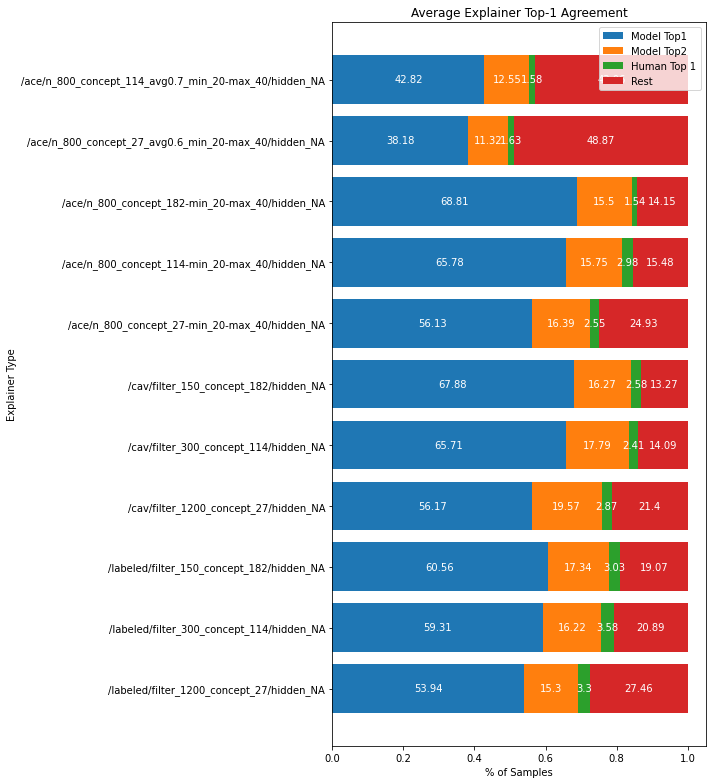

Saved plot to saved_explainers/ade20k/concepts/graphs/mean_explainer_top1_alignment_stacked_bar.png


In [25]:
legend = ['Model Top1', 'Model Top2', 'Human Top 1', 'Rest']

keys = ['me_overall', 'm2e_overall', 'me_misaligned_h1e_overall', 'me_misaligned_rest']
across_trial_overalls = {}
for key in keys:
    across_trial_overalls[key] = []
    
across_trial_means = []
across_trial_stds = []
id_head = 'concepts'
explainer_ids = []
parents = []

graph = False
for idx, (_, repeated_trials_parent) in enumerate(paths):
    parents.append(repeated_trials_parent)
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    graph_save_dir = os.path.join(repeated_trials_parent, 'graphs')
    ensure_dir(graph_save_dir)
    
    # Get explainer ID based on path
    explainer_id = repeated_trials_parent.split(id_head)[1]
    explainer_ids.append(explainer_id)
    
    # Get n_samples in each partition
    overalls = []
    means = []
    stds = []
    # obtain the number of samples in each partition for this all trials
    for key in keys:
        n_overall, n_mean, n_std = get_n_samples(partition_idxs, key)
        overalls.append(n_overall) # n_overall is a list of n_trials length
        means.append(n_mean)
        stds.append(n_std)
        across_trial_overalls[key].append(n_overall)

    # Graph for repeated trials
    save_path = os.path.join(graph_save_dir, 'explainer_top1_alignment_stacked_bar.png')
    if graph:
        stacked_horizontal_bar_chart(
            data=overalls,
            bar_height=0.6,
            labels=['Trial {}'.format(i+1) for i in range(len(overalls[0]))],
            display_values='absolute',
            legend=legend,
            xlabel='Number of Samples',
            ylabel='Trial Number',
            title='{} Explainer Top-1 Agreement'.format(explainer_id),
            fig_size=(10, 8),
            save_path=save_path)
        print("Saved plot to {}".format(save_path))
    
    across_trial_means.append(means)
    across_trial_stds.append(stds)
    
# Transpose means and stds from so each row corresponds with a bar section
across_trial_means = np.array(across_trial_means).T
across_trial_stds = np.array(across_trial_stds).T
print(across_trial_means)

# Graph for average across repeated trials while varying explainer
shared_dir = os.path.commonpath(parents)
shared_graph_dir = os.path.join(shared_dir, 'graphs')
ensure_dir(shared_graph_dir)
save_path = os.path.join(shared_graph_dir, 'mean_explainer_top1_alignment_stacked_bar.png')
stacked_horizontal_bar_chart(
    data=across_trial_means, 
    bar_height=0.8,
    labels=explainer_ids,
    display_values='relative',
    legend=legend,
    xlabel='% of Samples',
    ylabel='Explainer Type',
    title='Average Explainer Top-1 Agreement',
    fig_size=(10, len(paths)),
    save_path=save_path)
print("Saved plot to {}".format(save_path))

<Figure size 432x288 with 0 Axes>

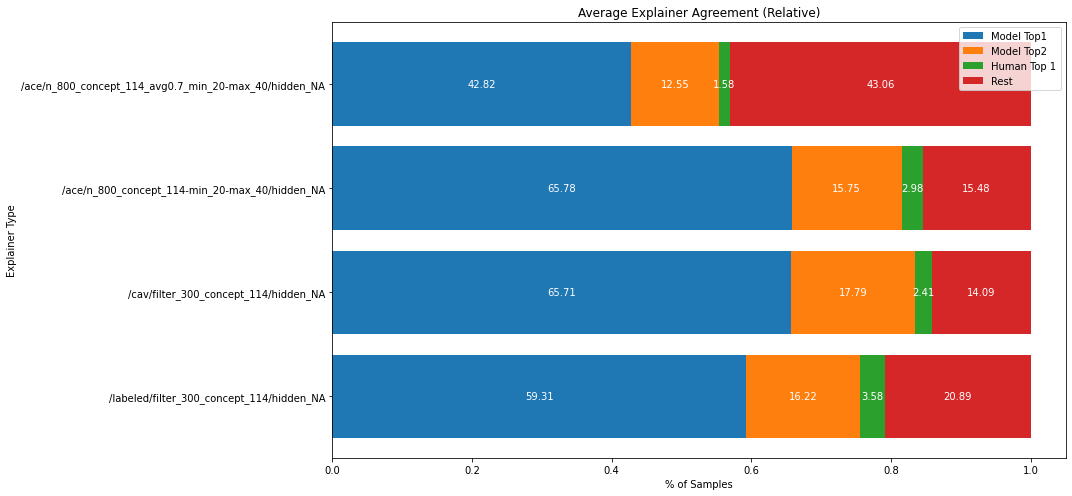

Saved plot to saved_explainers/ade20k/concepts/graphs/temp_mean_explainer_top1_alignment_stacked_bar.png


In [26]:
# select_idxs = [0, 3, 6, 9] # 25/27 concepts
select_idxs = [1, 4, 7, 10] # 100/114 concepts
# select_idxs = [2, 5, 8] # 182 concepts
# Graph for average across repeated trials while varying explainer
shared_dir = os.path.commonpath(parents)
shared_graph_dir = os.path.join(shared_dir, 'graphs')
ensure_dir(shared_graph_dir)

save_path = os.path.join(shared_graph_dir, 'temp_mean_explainer_top1_alignment_stacked_bar.png')
stacked_horizontal_bar_chart(
    data=across_trial_means[:, select_idxs], 
    bar_height=0.8,
    labels=np.array(explainer_ids)[select_idxs],
    display_values='relative',
    legend=legend,
    xlabel='% of Samples',
    ylabel='Explainer Type',
    title="Average Explainer Agreement (Relative)",
    fig_size=(15, len(select_idxs)+3),
    save_path=save_path)
print("Saved plot to {}".format(save_path))

### Examine Overlap of images in HnM

In [30]:
debug = True
# key = 'me_overall'
# key = 'm2e_overall'
# key = 'me_misaligned_h1e_overall'
key = 'me_misaligned_rest'
intersections = []
unions = []
for idx, (_, repeated_trials_parent) in enumerate(paths):
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    trial_intersection = set.intersection(*partition_idxs[key])
    trial_union = set.union(*partition_idxs[key])
    
    intersections.append(trial_intersection)
    unions.append(trial_union)
    print("Explanation: {}".format(repeated_trials_parent))
    print("Intersection: {} samples across all trials: {}".format(len(trial_intersection), trial_intersection))
    print("Union: {} samples across all trials: {}".format(len(trial_union), trial_union))
    print("")

Explanation: saved_explainers/ade20k/concepts/labeled/filter_attr_1200/hidden_NA
Intersection: 205 samples across all trials: {514, 4, 5, 519, 8, 9, 16, 21, 536, 542, 546, 547, 36, 37, 40, 42, 43, 555, 45, 49, 50, 52, 53, 564, 60, 572, 575, 576, 581, 582, 72, 76, 79, 591, 84, 85, 86, 88, 606, 98, 101, 615, 104, 616, 621, 110, 624, 113, 115, 116, 630, 632, 120, 634, 122, 128, 644, 647, 145, 658, 147, 659, 149, 151, 153, 671, 161, 676, 165, 679, 168, 683, 684, 686, 689, 691, 181, 187, 190, 703, 192, 193, 708, 710, 712, 202, 206, 720, 723, 213, 729, 730, 732, 733, 734, 225, 738, 739, 229, 233, 234, 235, 236, 749, 751, 754, 756, 249, 251, 252, 764, 254, 767, 258, 259, 260, 771, 263, 776, 267, 780, 781, 782, 271, 273, 785, 787, 277, 278, 792, 283, 284, 801, 802, 803, 804, 296, 812, 303, 304, 818, 821, 822, 312, 318, 319, 832, 321, 837, 328, 329, 333, 845, 335, 338, 854, 855, 856, 349, 865, 354, 867, 358, 359, 870, 361, 873, 874, 366, 367, 368, 882, 889, 388, 901, 390, 903, 906, 397, 910, 40

In [31]:
#select_idxs = [0, 3, 6] # 25/27 concepts
# select_idxs = [1, 4, 7] # 100/114 concepts
# select_idxs = [2, 5, 8] # 182 concepts
select_idxss = {
    "low": [0, 3, 6],
    "medium": [1, 4, 7],
    "high": [2, 5, 8]
}

aggregation_types = [
    ('intersection', intersections),
    ('union', unions)
]
verbose = False
for key, select_idxs in select_idxss.items():
    labeled_idx, cav_idx, ace_idx = select_idxs
    print("Printing overlap for {} number of concepts".format(key))
    
    if verbose:
        print("Labeled path: {}".format(paths[labeled_idx][1]))
        print("CAV path: {}".format(paths[cav_idx][1]))
        print("ACE path: {}".format(paths[ace_idx][1]))
    for (agg_type, agg_data) in aggregation_types:
        labeled_agg = agg_data[labeled_idx]
        cav_agg = agg_data[cav_idx]
        ace_agg = agg_data[ace_idx]
        # IOU of ace and cav
        print("IOU of ACE and CAV trial {}: {}/{} ({:.3f})".format(
            agg_type,
            len(ace_agg.intersection(cav_agg)),
            len(ace_agg.union(cav_agg)),
            len(ace_agg.intersection(cav_agg)) / len(ace_agg.union(cav_agg))))

        print("IOU of ACE and Labeled trial {}: {}/{} ({:.3f})".format(
            agg_type,
            len(ace_agg.intersection(labeled_agg)),
            len(ace_agg.union(labeled_agg)),
            len(ace_agg.intersection(labeled_agg)) / len(ace_agg.union(labeled_agg))))

        print("IOU of CAV and Labeled trial {}: {}/{} ({:.3f})".format(
            agg_type,
            len(cav_agg.intersection(labeled_agg)),
            len(cav_agg.union(labeled_agg)),
            len(cav_agg.intersection(labeled_agg)) / len(cav_agg.union(labeled_agg))))
        print("")
# Compare 25/27 concepts
# Intersection


Printing overlap for low number of concepts
IOU of ACE and CAV trial intersection: 86/326 (0.264)
IOU of ACE and Labeled trial intersection: 109/349 (0.312)
IOU of CAV and Labeled trial intersection: 93/271 (0.343)

IOU of ACE and CAV trial union: 148/416 (0.356)
IOU of ACE and Labeled trial union: 175/449 (0.390)
IOU of CAV and Labeled trial union: 186/414 (0.449)

Printing overlap for medium number of concepts
IOU of ACE and CAV trial intersection: 27/180 (0.150)
IOU of ACE and Labeled trial intersection: 47/242 (0.194)
IOU of CAV and Labeled trial intersection: 50/210 (0.238)

IOU of ACE and CAV trial union: 92/338 (0.272)
IOU of ACE and Labeled trial union: 127/395 (0.322)
IOU of CAV and Labeled trial union: 126/324 (0.389)

Printing overlap for high number of concepts
IOU of ACE and CAV trial intersection: 21/143 (0.147)
IOU of ACE and Labeled trial intersection: 29/214 (0.136)
IOU of CAV and Labeled trial intersection: 40/193 (0.207)

IOU of ACE and CAV trial union: 76/312 (0.244

### T-test stuff (probably throw this out)

In [105]:
def calculate_ttest_pairs(data, names):
    assert len(data) == len(names)
    
    ttests = []
    for i, (name_i, data_i) in enumerate(zip(names[:-1], data[:-1])):
        for j, (name_j, data_j) in enumerate(zip(names[i+1:], data[i+1:])):
            ttest = stats.ttest_ind(data_i, data_j)
            ttests.append(ttest)
            print("{} vs {}: {} (p={})".format(name_i, name_j, ttest.statistic, ttest.pvalue))
    return ttests

def calculate_ttest(semantic, nonsemantic):
    ttest = stats.ttest_ind(semantic, nonsemantic, alternative='greater')
    print("Ha: Semantic > Non-semantic: {} (p={})".format(ttest.statistic, ttest.pvalue))

#### T-tests for human alignment overall

In [133]:
# select_idxs = [0, 3, 6] # 25/27 concepts
# select_idxs = [1, 4, 7] # 100/114 concepts
# select_idxs = [2, 5, 8] # 182 concepts
human_aligned_samples = across_trial_overalls['me_misaligned_h1e_overall']
for idx, row in enumerate(human_aligned_samples):
    print(idx, row)
    
    
# 25 concepts
ace = human_aligned_samples[6]
cav = human_aligned_samples[3]
labeled = human_aligned_samples[0]

print("25 concepts")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)

calculate_ttest_pairs(
    data=[ace, cav, labeled],
    names=['ace', 'cav', 'labeled'])


# 100 concepts
select_idxs = [1, 4, 7] # 100/114 concepts
ace = human_aligned_samples[7]
cav = human_aligned_samples[4]
labeled = human_aligned_samples[1]
print("100 concepts")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)
calculate_ttest_pairs(
    data=np.array(human_aligned_samples)[select_idxs],
    names=['labeled', 'cav', 'ace'])

# 182 concepts
select_idxs = [2, 5, 8] # 182 concepts
ace = human_aligned_samples[8]
cav = human_aligned_samples[5]
labeled = human_aligned_samples[2]
print("182 concepts")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)
calculate_ttest_pairs(
    data=np.array(human_aligned_samples)[select_idxs],
    names=['labeled', 'cav', 'ace'])

0 [22, 24, 22, 21, 21, 23, 21, 21, 23, 23, 22, 25, 23, 23, 23, 23, 25, 24, 22, 25]
1 [21, 22, 21, 20, 20, 21, 22, 20, 20, 21, 21, 20, 21, 20, 21, 22, 21, 20, 22, 21]
2 [25, 24, 26, 26, 26, 25, 27, 25, 26, 26, 25, 25, 24, 27, 23, 26, 26, 25, 26, 25]
3 [21, 21, 19, 20, 21, 21, 23, 22, 23, 21, 22, 17, 21, 21, 20, 21, 20, 18, 22, 21]
4 [17, 19, 16, 15, 17, 16, 20, 18, 19, 18, 15, 19, 19, 18, 16, 18, 19, 19, 16, 20]
5 [21, 20, 22, 23, 23, 22, 23, 23, 23, 21, 24, 21, 21, 21, 26, 25, 25, 20, 25, 25]
6 [21, 21, 21, 20, 22, 21, 19, 20, 19, 21, 22, 20, 21, 21, 19, 23, 23, 22, 22, 22]
7 [13, 16, 17, 16, 19, 17, 17, 16, 17, 16, 16, 17, 16, 17, 16, 16, 18, 21, 17, 19]
8 [17, 22, 21, 20, 20, 20, 20, 19, 18, 19, 15, 19, 16, 20, 18, 17, 19, 16, 19, 18]
25 concepts
cav vs ace
Ha: Semantic > Non-semantic: -0.5835253140307585 (p=0.7185062918199878)
labeled vs ace
Ha: Semantic > Non-semantic: 4.4852700095784135 (p=3.265594475011609e-05)
ace vs cav: 0.5835253140307585 (p=0.5629874163600245)
ace vs labeled:

[Ttest_indResult(statistic=5.7771882100601335, pvalue=1.1508969198757444e-06),
 Ttest_indResult(statistic=14.771415199442771, pvalue=2.4844940124535084e-17),
 Ttest_indResult(statistic=7.068488314633351, pvalue=1.987187678196129e-08)]

#### T-test for human alignment over all misaligned samples

In [134]:
human_aligned_samples = np.array(across_trial_overalls['me_misaligned_h1e_overall'])
rest_samples = np.array(across_trial_overalls['me_misaligned_rest'])

misaligned_samples = human_aligned_samples + rest_samples
human_over_misaligned_proportions = human_aligned_samples / misaligned_samples

# 25 concepts
print("25 concepts")
ace = human_over_misaligned_proportions[6]
cav = human_over_misaligned_proportions[3]
labeled = human_over_misaligned_proportions[0]
print("two-sided")
calculate_ttest_pairs(
    data=[ace, cav, labeled],
    names=['ace', 'cav', 'labeled'])

print("1 sided (semantic >)")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)

# 100 concepts
select_idxs = [1, 4, 7] # 100/114 concepts
ace = human_over_misaligned_proportions[7]
cav = human_over_misaligned_proportions[4]
labeled = human_over_misaligned_proportions[1]
print("\n100 concepts")

print("two-sided")
calculate_ttest_pairs(
    data=np.array(human_over_misaligned_proportions)[select_idxs],
    names=['labeled', 'cav', 'ace'])

print("1 sided (semantic >)")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)

# 182 concepts
select_idxs = [2, 5, 8] # 182 concepts
ace = human_over_misaligned_proportions[8]
cav = human_over_misaligned_proportions[5]
labeled = human_over_misaligned_proportions[2]
print("182 concepts")
print("cav vs ace")
calculate_ttest(
    semantic=cav,
    nonsemantic=ace)
print("labeled vs ace")
calculate_ttest(
    semantic=labeled,
    nonsemantic=ace)
calculate_ttest_pairs(
    data=np.array(human_over_misaligned_proportions)[select_idxs],
    names=['labeled', 'cav', 'ace'])


25 concepts
two-sided
ace vs cav: -10.87987190457381 (p=3.1125243065849453e-13)
ace vs labeled: -5.374197747170008 (p=4.104232805550155e-06)
cav vs labeled: 7.22870305654933 (p=1.2086339934570438e-08)
1 sided (semantic >)
cav vs ace
Ha: Semantic > Non-semantic: 10.87987190457381 (p=1.5562621532924726e-13)
labeled vs ace
Ha: Semantic > Non-semantic: 5.374197747170008 (p=2.0521164027750773e-06)

100 concepts
two-sided
labeled vs cav: -12.8377070353905 (p=2.153270726044558e-15)
labeled vs ace: 0.40578040975681046 (p=0.6871798454874645)
cav vs ace: 10.674768223914217 (p=5.391013547193962e-13)
1 sided (semantic >)
cav vs ace
Ha: Semantic > Non-semantic: 10.674768223914217 (p=2.695506773596981e-13)
labeled vs ace
Ha: Semantic > Non-semantic: 0.40578040975681046 (p=0.34358992274373223)
182 concepts
cav vs ace
Ha: Semantic > Non-semantic: 12.277353033644712 (p=4.256428905568905e-15)
labeled vs ace
Ha: Semantic > Non-semantic: -1.955672553105436 (p=0.9710571007073805)
labeled vs cav: -17.039306

[Ttest_indResult(statistic=-17.039306345900673, pvalue=2.189158981522801e-19),
 Ttest_indResult(statistic=-1.955672553105436, pvalue=0.05788579858523914),
 Ttest_indResult(statistic=12.277353033644712, pvalue=8.51285781113781e-15)]

### Plot human uncertainty in different breakdowns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_NA
Across trials, human uncertainty for case1: 0.1942181107932701 (0.025175850323164606)
Across trials, human uncertainty for case2: 0.5569381578376535 (0.04549083234441056)
Across trials, human uncertainty for case3: 0.32143729256722847 (0.037826027978402316)
Across trials, human uncertainty for case4: 0.27914849327473507 (0.08426795688886635)
Across trials, human uncertainty for case5: 0.6180607735134785 (0.06775645847819747)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


<Figure size 432x288 with 0 Axes>

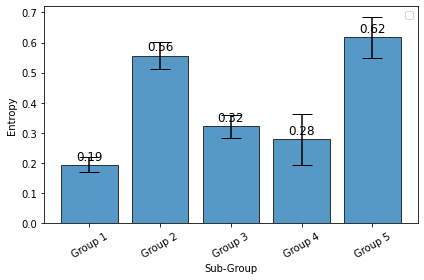

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128
Across trials, human uncertainty for case1: 0.1959089509277053 (0.024412235894896318)
Across trials, human uncertainty for case2: 0.558079410851081 (0.04586296697190169)
Across trials, human uncertainty for case3: 0.3336154207832444 (0.0404180028247536)
Across trials, human uncertainty for case4: 0.27858815465043685 (0.08323651884197471)
Across trials, human uncertainty for case5: 0.6171309020401594 (0.06760437740342115)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


<Figure size 432x288 with 0 Axes>

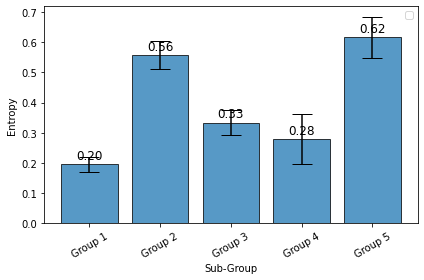

Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_128_128
Across trials, human uncertainty for case1: 0.19402949123253238 (0.02461445523370452)
Across trials, human uncertainty for case2: 0.564948349476383 (0.045239528666024834)
Across trials, human uncertainty for case3: 0.3307920725904364 (0.03950353795568874)
Across trials, human uncertainty for case4: 0.25528923400232945 (0.082616156208157)
Across trials, human uncertainty for case5: 0.6094655281821193 (0.06812411591809532)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

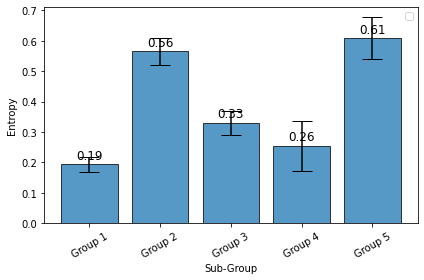

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256
Across trials, human uncertainty for case1: 0.19920299405370706 (0.024481729179150192)
Across trials, human uncertainty for case2: 0.5557055507695694 (0.045848966496563226)
Across trials, human uncertainty for case3: 0.3282156811846519 (0.04075933349233829)
Across trials, human uncertainty for case4: 0.2897751327846007 (0.08430911843820149)
Across trials, human uncertainty for case5: 0.6149837688656464 (0.0680295412207967)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


<Figure size 432x288 with 0 Axes>

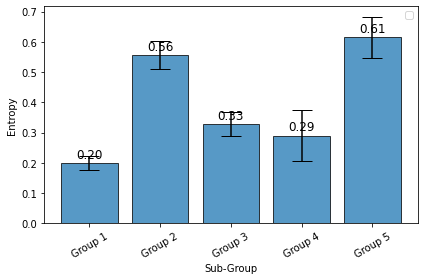

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_256_256
Across trials, human uncertainty for case1: 0.1931517161751557 (0.024418775968416566)
Across trials, human uncertainty for case2: 0.548729507056039 (0.04707072703905365)
Across trials, human uncertainty for case3: 0.339936433971911 (0.0400053471310389)
Across trials, human uncertainty for case4: 0.320271656874529 (0.08561961597070275)
Across trials, human uncertainty for case5: 0.630635255720889 (0.06547451959374669)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


<Figure size 432x288 with 0 Axes>

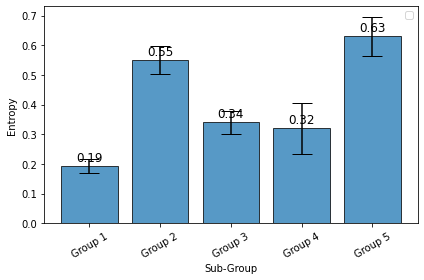

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating human entropy graph for saved_explainers/ade20k/concepts/labeled/n_1200/hidden_1024
Across trials, human uncertainty for case1: 0.19750442439395804 (0.024530557374369676)
Across trials, human uncertainty for case2: 0.5607450379615446 (0.04597846156319286)
Across trials, human uncertainty for case3: 0.3292066771057906 (0.040270888456195794)
Across trials, human uncertainty for case4: 0.3096311982631341 (0.0808606218302398)
Across trials, human uncertainty for case5: 0.6129933382708675 (0.06970299825579765)
[0.188455569033831, 0.1880366109581741, 0.1880773769810953, 0.19090498571824066, 0.20269240456967155, 0.19176405192185575, 0.19210534430376694, 0.19084160594918478, 0.19969520661790993, 0.1956390974384238, 0.19969520661790993, 0.1926059331370529, 0.1926059331370529, 0.19532558366537045, 0.1984711912206048, 0.188455569033831, 0.19347934251247376, 0.20148736615527035, 0.19508685569595816, 0.19893698119772368]


<Figure size 432x288 with 0 Axes>

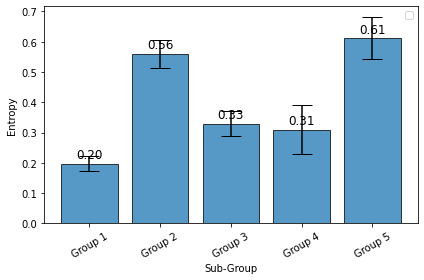

In [42]:
def get_trial_mean_ses(human_model_df, 
                       column_name,
                       idx_list):
    '''
    Return 2 lists: mean and SE of the column_name from each idx list
    
    '''
    if column_name not in human_model_df:
        raise ValueError("{} not in df.".format(column_name))
    means = []
    ses = []
    for idxs in idx_list:
        trial_entropies = human_model_df[column_name].iloc[list(idxs)].to_numpy()
        # Calculate mean and SE for this value from this trial
        means.append(np.mean(trial_entropies))
        ses.append(np.std(trial_entropies) / np.sqrt(len(trial_entropies)))
        
    assert len(means) == len(idx_list)
    assert len(ses) == len(idx_list)
    return means, ses
        
for idx, (_, repeated_trials_parent) in enumerate(paths):
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    
    n_trials = len(os.listdir(repeated_trials_dir))
    
    human_model_df = pd.read_csv(os.path.join(repeated_trials_parent, 'human_model_uncertainties_alignment.csv'))
    # Obtain human uncertainty for all samples
    human_uncertainty = human_model_df['human_entropy']

    means = []
    ses = []
    print("Creating human entropy graph for {}".format(repeated_trials_parent))
    for key, list_val in group_human_uncertainties.items():
        # List with mean uncertainty in each trial
        human_entropy_means, human_entropy_ses = get_human_entropy(
            human_model_df=human_model_df,
            idx_list=partition_idxs[key])

        means.append(np.mean(human_entropy_means))
        ses.append(np.mean(human_entropy_ses))
        print("Across trials, human uncertainty for {}: {} ({})".format(
            key, np.mean(human_entropy_means), np.mean(human_entropy_ses)))
    # print(len(ses[0]))
    print(group_human_uncertainties['case1'])
    fig, ax = bar_graph(
        data=[means],
        errors=[ses], 
        display_values=True,
        xlabel='Sub-Group',
        labels=['Group {}'.format(i) for i in range(1, 6)],
        xlabel_rotation=30,
        ylabel='Entropy',
        show=True)
    
    

### Graph overall model-explainer alignment as explainer complexity increases

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

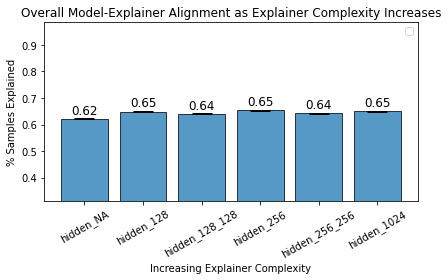

In [100]:
mean_me_aligned = []
se_me_aligned = []
labels = []
top_k = [1]
for idx, (_, repeated_trials_parent) in enumerate(paths):
    labels.append(os.path.basename(repeated_trials_parent))
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    
    n_trials = len(os.listdir(repeated_trials_dir))
    n_samples = len(partition_idxs['all_idxs'][0])
    
    # Define alignment by top 2 accuracy
    if 1 in top_k and 2 in top_k:
        n_me_aligned = []
        for i in range(n_trials):
            me_aligned = partition_idxs['me_overall'][i].union(partition_idxs['me2_overall'][i])
            n_me_aligned.append(len(me_aligned) / n_samples)

    # Define alignment by top 1 accuracy
    elif 1 in top_k:
        n_me_aligned = [len(me_aligned) / n_samples for me_aligned in partition_idxs['me_overall']]
    # Define alignment by only second prediction
    elif 2 in top_k:
        n_me_aligned = [len(me_aligned) / n_samples for me_aligned in partition_idxs['me2_overall']]
    else:
        raise ValueError("Unsupported values for top_k received: {}".format(top_k))
    mean_me_aligned.append(np.mean(n_me_aligned))
    se_me_aligned.append(np.std(n_me_aligned) / np.sqrt(len(n_me_aligned)))
    
ymax = 1.5 * (np.max(mean_me_aligned) + np.max(se_me_aligned))
ymin = 0.5 * (np.min(mean_me_aligned) + np.max(se_me_aligned))

fig, ax = bar_graph(
    data=[mean_me_aligned],
    errors=[se_me_aligned], 
    display_values=True,
    xlabel='Increasing Explainer Complexity',
    labels=labels,
    xlabel_rotation=30,
    ylabel='% Samples Explained',
    title='Overall Model-Explainer Alignment as Explainer Complexity Increases',
    ylim=[ymin, ymax],
    show=True)
    

### Graph model-explainer alignment when model is correct as explainer complexity increases

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', '

<Figure size 432x288 with 0 Axes>

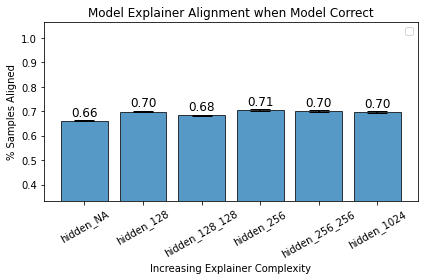

In [84]:
mean_me_aligned = []
se_me_aligned = []
labels = []

for idx, (_, repeated_trials_parent) in enumerate(paths):
    labels.append(os.path.basename(repeated_trials_parent))
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    print(partition_idxs.keys())
    
    n_trials = len(os.listdir(repeated_trials_dir))
    n_samples = len(partition_idxs['all_idxs'])
    
    hm_aligned_idxs = partition_idxs['hm_overall']

    me_aligned_overall_idxs = partition_idxs['me_overall']
    assert len(hm_aligned_idxs) == len(me_aligned_overall_idxs)
    
    me_aligned_model_correct = []
    for hm_aligned, me_aligned_overall in zip(hm_aligned_idxs, me_aligned_overall_idxs):
        me_aligned_model_correct.append(len(hm_aligned.intersection(me_aligned_overall)) / len(hm_aligned))
        
    # Add mean and standard error for each explainer here
    mean_me_aligned.append(np.mean(me_aligned_model_correct))
    se_me_aligned.append(np.std(me_aligned_model_correct) / np.sqrt(len(me_aligned_model_correct)))

    
ymax = 1.5 * (np.max(mean_me_aligned) + np.max(se_me_aligned))
ymin = 0.5 * (np.min(mean_me_aligned) + np.max(se_me_aligned))
fig, ax = bar_graph(
    data=[mean_me_aligned],
    errors=[se_me_aligned], 
    display_values=True,
    xlabel='Increasing Explainer Complexity',
    labels=labels,
    xlabel_rotation=30,
    ylabel='% Samples Aligned',
    title='Model Explainer Alignment when Model Correct',
    ylim=[ymin, ymax],
    show=True)
    

### Graph model-explainer alignment when model is incorrect as explainer complexity increases

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', '

<Figure size 432x288 with 0 Axes>

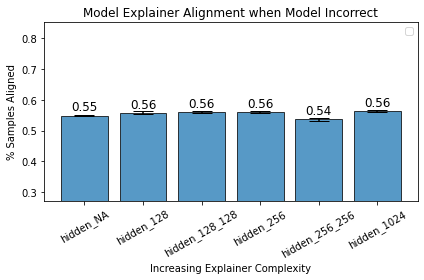

In [83]:
mean_me_aligned = []
se_me_aligned = []
labels = []

for idx, (_, repeated_trials_parent) in enumerate(paths):
    labels.append(os.path.basename(repeated_trials_parent))
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    print(partition_idxs.keys())
    
    n_trials = len(os.listdir(repeated_trials_dir))
    n_samples = len(partition_idxs['all_idxs'])
    
    hm_misaligned_idxs = []
    for all_idxs, hm_overall_idxs in zip(partition_idxs['all_idxs'], partition_idxs['hm_overall']):
        hm_misaligned_idxs.append(all_idxs - hm_overall_idxs)

    me_aligned_overall_idxs = partition_idxs['me_overall']
    assert len(hm_misaligned_idxs) == len(me_aligned_overall_idxs)
    
    me_aligned_model_incorrect = []
    for hm_misaligned, me_aligned_overall in zip(hm_misaligned_idxs, me_aligned_overall_idxs):
        me_aligned_model_incorrect.append(len(hm_misaligned.intersection(me_aligned_overall)) / len(hm_misaligned))
        
    mean_me_aligned.append(np.mean(me_aligned_model_incorrect))
    se_me_aligned.append(np.std(me_aligned_model_incorrect) / np.sqrt(len(me_aligned_model_incorrect)))
    # mean_me_aligned.append(np.mean(n_me_aligned))
    # se_me_aligned.append(np.std(n_me_aligned) / np.sqrt(len(n_me_aligned)))
    
ymax = 1.5 * (np.max(mean_me_aligned) + np.max(se_me_aligned))
ymin = 0.5 * (np.min(mean_me_aligned) + np.max(se_me_aligned))
fig, ax = bar_graph(
    data=[mean_me_aligned],
    errors=[se_me_aligned], 
    display_values=True,
    xlabel='Increasing Explainer Complexity',
    labels=labels,
    xlabel_rotation=30,
    ylabel='% Samples Aligned',
    title='Model Explainer Alignment when Model Incorrect',
    ylim=[ymin, ymax],
    show=True)
    

### Graph human-explainer alignment when model is incorrect

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', 'case2', 'case3', 'case4', 'case5', 'me2_overall', 'he2_overall', 'me_rest_misaligned', 'he_rest_misaligned'])
dict_keys(['all_idxs', 'me_overall', 'he_overall', 'hm_overall', 'case1', '

<Figure size 432x288 with 0 Axes>

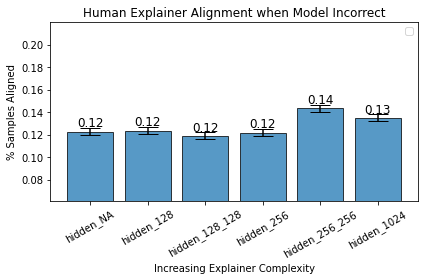

In [80]:
mean_he_aligned = []
se_he_aligned = []
labels = []


for idx, (_, repeated_trials_parent) in enumerate(paths):
    labels.append(os.path.basename(repeated_trials_parent))
    repeated_trials_dir = os.path.join(repeated_trials_parent, 'repeated_trials')
    repeated_trials_analysis_dir = os.path.join(repeated_trials_parent, 'repeated_trials_analysis')
    partition_idxs_path = os.path.join(repeated_trials_analysis_dir, 'repeated_trials_partition_idxs.pth')
    partition_idxs = torch.load(partition_idxs_path)
    print(partition_idxs.keys())
    
    n_trials = len(os.listdir(repeated_trials_dir))
    n_samples = len(partition_idxs['all_idxs'])
    
    hm_misaligned_idxs = []
    for all_idxs, hm_overall_idxs in zip(partition_idxs['all_idxs'], partition_idxs['hm_overall']):
        hm_misaligned_idxs.append(all_idxs - hm_overall_idxs)

    he_aligned_overall_idxs = partition_idxs['he_overall']
    assert len(hm_misaligned_idxs) == len(he_aligned_overall_idxs)
    
    he_aligned_model_incorrect = []
    for hm_misaligned, he_aligned_overall in zip(hm_misaligned_idxs, he_aligned_overall_idxs):
        he_aligned_model_incorrect.append(len(hm_misaligned.intersection(he_aligned_overall)) / len(hm_misaligned))
        
    mean_he_aligned.append(np.mean(he_aligned_model_incorrect))
    se_he_aligned.append(np.std(me_aligned_model_incorrect) / np.sqrt(len(he_aligned_model_incorrect)))
    
ymax = 1.5 * (np.max(mean_he_aligned) + np.max(se_he_aligned))
ymin = 0.5 * (np.min(mean_he_aligned) + np.max(se_he_aligned))
fig, ax = bar_graph(
    data=[mean_he_aligned],
    errors=[se_he_aligned], 
    display_values=True,
    xlabel='Increasing Explainer Complexity',
    labels=labels,
    xlabel_rotation=30,
    ylabel='% Samples Aligned',
    title='Human Explainer Alignment when Model Incorrect',
    ylim=[ymin, ymax],
    show=True)
    